In [5]:
import pandas as pd
import numpy as np

# Preprocessing et pipeline
from sklearn.preprocessing import RobustScaler
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics

# Modeles
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import r2_score, mean_absolute_error

#data viz
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# fonction pour tester un modèle

def model_testing(data, model, parameters):
    # Numerical variables
    column_num = ['decade', 'runtimeMinutes', "isAdult"]
    transfo_num = Pipeline(steps=[
        ('scaling', RobustScaler())
    ])

    # Categorical variables
    column_tex1 = 'genres'
    column_tex2 = 'actors'
    column_tex3 = 'actress'
    column_tex4 = 'directors'

    transfo_tex = Pipeline(steps=[
        ('countvec', CountVectorizer(tokenizer=lambda x: x.split(',')))
        ])

    # Class ColumnTransformer : apply alls steps on the whole dataset
    preparation = ColumnTransformer(
        transformers=[
            ('data_tex1', transfo_tex , column_tex1),
            ('data_tex2', transfo_tex , column_tex2),
            ('data_tex3', transfo_tex , column_tex3),
            ('data_tex4', transfo_tex , column_tex4),
            ('data_num', transfo_num , column_num)
        ])

    # Create pipeline
    pipe = Pipeline(steps=[('preparation', preparation),
                            ('model', model)])


    # Declare the Grid Search method
    grid = GridSearchCV(pipe, parameters, scoring='r2', cv = 3, n_jobs =-1, verbose = 1)

    # Fit the model
    y = data['averageRating']
    X = data.drop(columns='averageRating')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # fit le gridsearch
    grid.fit(X_train, y_train)


    # print resultats:

    # Evaluate model performance with predictions
    y_pred = grid.predict(X_test)

    # Evaluate cross validation performance 
    print("CV parameters:", grid.best_params_)
    print("CV score - R2:", grid.best_score_)
    print("Test score r2", r2_score(y_test, y_pred))
    print("Test score MAE", mean_absolute_error(y_test, y_pred))

In [7]:
# fonction pour tester les 3 clusters à la suite: 
def model_testing_cluster(cluster_datasets, model, parameters):
    num = 0
    for i in cluster_datasets:
        print("__________________________________________")
        print(f"Pour le dataset {num}, le meilleur modèle est:")
        model_testing(i, model, parameters)
        num += 1

# I. Création du dataset

In [8]:
# Creation du dataset
df_all = pd.read_csv('../datasets/data_regression_sylvine.csv', index_col=0)
df_all = df_all.drop('tconst', axis=1)
df_all.head()

,actors,averageRating,numVotes,decade,runtimeMinutes,isAdult,genres,directors,actress
0,"nm0585785,nm0707778,nm0166547,nm0473134",6.2,31,191.0,45.0,0,NaN,nm0300487,"nm0631025,nm0003425,nm1270556,nm1495634"
1,"nm0846894,nm1431224,nm3002376",6.0,808,190.0,70.0,0,"Action,Adventure,Biography",nm0846879,nm0846887
2,"nm0064953,nm0085066,nm0169878,nm0299757,nm1834...",4.6,19,191.0,NaN,0,Crime,nm0375839,nm0630641
3,"nm0104856,nm0251436,nm0526190,nm5188470,nm5217890",3.5,17,190.0,NaN,0,"Drama,War",nm0022607,"nm1834127,nm0280746,nm0762935"
4,nm0735618,3.8,21,191.0,58.0,0,"Adventure,Drama","nm0063413,nm0550220",nm0699807


In [9]:
df_3000 = df_all[df_all['numVotes'] > 3000]
df_3000 = df_3000.drop('numVotes', axis=1).dropna(subset="averageRating")

df_all = df_all.drop('numVotes', axis=1).dropna(subset="averageRating")
df_all.head()

,actors,averageRating,decade,runtimeMinutes,isAdult,genres,directors,actress
0,"nm0585785,nm0707778,nm0166547,nm0473134",6.2,191.0,45.0,0,NaN,nm0300487,"nm0631025,nm0003425,nm1270556,nm1495634"
1,"nm0846894,nm1431224,nm3002376",6.0,190.0,70.0,0,"Action,Adventure,Biography",nm0846879,nm0846887
2,"nm0064953,nm0085066,nm0169878,nm0299757,nm1834...",4.6,191.0,NaN,0,Crime,nm0375839,nm0630641
3,"nm0104856,nm0251436,nm0526190,nm5188470,nm5217890",3.5,190.0,NaN,0,"Drama,War",nm0022607,"nm1834127,nm0280746,nm0762935"
4,nm0735618,3.8,191.0,58.0,0,"Adventure,Drama","nm0063413,nm0550220",nm0699807


In [10]:
# Creation du dataset
df_all = pd.read_csv('../datasets/data_regression_sylvine.csv', index_col=0)
df_all = df_all.drop('tconst', axis=1)
df_all.head()

,actors,averageRating,numVotes,decade,runtimeMinutes,isAdult,genres,directors,actress
0,"nm0585785,nm0707778,nm0166547,nm0473134",6.2,31,191.0,45.0,0,NaN,nm0300487,"nm0631025,nm0003425,nm1270556,nm1495634"
1,"nm0846894,nm1431224,nm3002376",6.0,808,190.0,70.0,0,"Action,Adventure,Biography",nm0846879,nm0846887
2,"nm0064953,nm0085066,nm0169878,nm0299757,nm1834...",4.6,19,191.0,NaN,0,Crime,nm0375839,nm0630641
3,"nm0104856,nm0251436,nm0526190,nm5188470,nm5217890",3.5,17,190.0,NaN,0,"Drama,War",nm0022607,"nm1834127,nm0280746,nm0762935"
4,nm0735618,3.8,21,191.0,58.0,0,"Adventure,Drama","nm0063413,nm0550220",nm0699807


In [11]:
df_3000 = df_all[df_all['numVotes'] > 3000]
df_3000 = df_3000.drop('numVotes', axis=1).dropna(subset="averageRating")

df_250 = df_all[df_all['numVotes'] > 250]
df_250 = df_250.drop('numVotes', axis=1).dropna()
df_250.shape

(64301, 8)

# II. Application d'un modèle avec une pipeline incluant GridSearch, étape par étape

In [12]:
df_3000.head()

,actors,averageRating,decade,runtimeMinutes,isAdult,genres,directors,actress
89,"nm0130740,nm0513325,nm0835738",5.7,193.0,66.0,0,"Crime,Mystery,Thriller",nm0000033,nm0340514
203,"nm0001196,nm0250366,nm0067634",7.7,192.0,155.0,0,"Adventure,Family,Fantasy",nm0909825,nm0426710
231,"nm0454558,nm0437304",5.6,192.0,100.0,0,"Drama,Musical,Romance",nm0064600,"nm0522281,nm0656105"
234,"nm0800302,nm0280961,nm0301224",7.5,193.0,91.0,0,"Crime,Drama",nm0719756,nm0546516
235,"nm0109895,nm0444602,nm0044024",6.2,192.0,110.0,0,"Drama,Romance",nm0000033,"nm0339504,nm0648565"


In [13]:
df_3000.dropna(inplace = True)
df_3000.shape

(17570, 8)

In [14]:
# Numerical variables
column_num = ['decade', 'runtimeMinutes', "isAdult"]
transfo_num = Pipeline(steps=[
    ('scaling', RobustScaler())
])

In [15]:
# Categorical variables
column_tex1 = 'genres'
column_tex2 = 'actors'
column_tex3 = 'actress'
column_tex4 = 'directors'

transfo_tex = Pipeline(steps=[
    ('countvec', CountVectorizer(tokenizer=lambda x: x.split(',')))
 
    ])

In [16]:
# Class ColumnTransformer : apply alls steps on the whole dataset
preparation = ColumnTransformer(
    transformers=[
        ('data_tex1', transfo_tex , column_tex1),
        ('data_tex2', transfo_tex , column_tex2),
        ('data_tex3', transfo_tex , column_tex3),
        ('data_tex4', transfo_tex , column_tex4),
        ('data_num', transfo_num , column_num)
    ])

In [17]:
# Display diagram
set_config(display="diagram")
preparation

ColumnTransformer(transformers=[('data_tex1',
                                 Pipeline(steps=[('countvec',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x7f14b402b8b0>))]),
                                 'genres'),
                                ('data_tex2',
                                 Pipeline(steps=[('countvec',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x7f14b402b8b0>))]),
                                 'actors'),
                                ('data_tex3',
                                 Pipeline(steps=[('countvec',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x7f14b402b8b0>))]),
                                 'actress'),
                                ('data_tex4',
                                 Pipeline(steps=[('countvec',
                                                  CountVectorizer(tokenizer=<function <lambda> at 0x7f14b402b8b0>))]),
                                 'directors'),
                                ('data_num',
                                 Pipeline(steps=[('scaling', RobustScaler())]),
                                 ['decade', 'runtimeMinutes', 'isAdult'])])

In [18]:
pipe = Pipeline(steps=[('preparation', preparation),
                        ('model', GradientBoostingRegressor())])
pipe

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_tex1',
                                                  Pipeline(steps=[('countvec',
                                                                   CountVectorizer(tokenizer=<function <lambda> at 0x7f14b402b8b0>))]),
                                                  'genres'),
                                                 ('data_tex2',
                                                  Pipeline(steps=[('countvec',
                                                                   CountVectorizer(tokenizer=<function <lambda> at 0x7f14b402b8b0>))]),
                                                  'actors'),
                                                 ('data_tex3',
                                                  Pipeline(steps=[('countvec',
                                                                   CountVectorizer(tokenizer=<function <lambda> at 0x7f14b402b8b0>))]),
                                                  'actress'),
                                                 ('data_tex4',
                                                  Pipeline(steps=[('countvec',
                                                                   CountVectorizer(tokenizer=<function <lambda> at 0x7f14b402b8b0>))]),
                                                  'directors'),
                                                 ('data_num',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['decade', 'runtimeMinutes',
                                                   'isAdult'])])),
                ('model', GradientBoostingRegressor())])

In [19]:
# Declare model and parameter for Grid Search
parameters = {'model__n_estimators': range(140, 150, 10), 'model__max_depth': range(6,7)}

In [20]:
# Declare the Grid Search method
grid = GridSearchCV(pipe, parameters, scoring='r2', cv = 5, n_jobs =-1, verbose = 1)

In [21]:
# Fit the model
y = df_3000['averageRating']
X = df_3000.drop(columns='averageRating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/dakoro/anaconda3/envs/Netfloox/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/dakoro/anaconda3/envs/Netfloox/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/dakoro/anaconda3/envs/Netfloox/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/dakoro/anaconda3/envs/Netfloox/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/dakoro/anaconda3/envs/Netfloox/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' 

KeyboardInterrupt: 

In [ ]:
# Evaluate cross validation performance 
print("CV parameters:", grid.best_params_)

CV parameters: {'model__max_depth': 6, 'model__n_estimators': 140}


In [ ]:
# Make predictions
y_pred = grid.predict(X_test)

In [ ]:
# Evaluate model performance
print("Test score r2", r2_score(y_test, y_pred))
print("Test score MAE", mean_absolute_error(y_test, y_pred))

Test score r2 0.37677030097383135
Test score MAE 0.6389165366189253


## Test du gradient boosting

In [ ]:
data = df_250
model = GradientBoostingRegressor()
parameters = {'model__n_estimators': range(140, 150, 10), 'model__max_depth': range(6,7)}

In [ ]:
model_testing(data, model, parameters) # ça tourne

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV parameters: {'model__max_depth': 6, 'model__n_estimators': 140}
CV score - R2: 0.3698111594741954
Test score r2 0.37479287545025786
Test score MAE 0.7472450657174414


## Test de Adaboost

In [ ]:
data = df_250
# model = AdaBoostRegressor()
# parameters = {'model__n_estimators': range(100, 201, 20)}

model = AdaBoostRegressor(n_estimators=175)
parameters = {}

model_testing(data, model, parameters)

# III. Approche par clustering

## (1) Détermination des clusters

In [ ]:
# on récupère une pipeline qui fait juste la tranformation
pipe_prep = Pipeline(steps=[('preparation', preparation)
                        ])

In [ ]:
# on l'applique sur le dataset avec transform 
res = pipe_prep.transform(df_250)

In [ ]:
res
# génère une sparse matrix qu'on pourra utiliser dans les analyses après

<64301x131040 sparse matrix of type '<class 'numpy.float64'>'
	with 590318 stored elements in Compressed Sparse Row format>

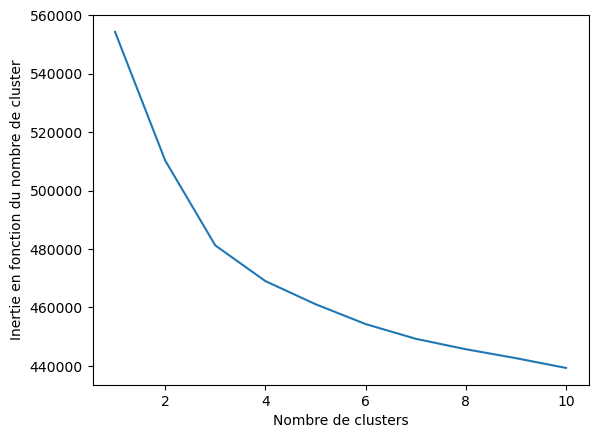

In [ ]:
# Nombre optimal de cluster 
def kOptimal(a, b, X):
    inertie = list()
    plage = range(a, b+1)
    for k in plage:
        km = KMeans(n_clusters=k).fit(X)
        inertie.append(km.inertia_)
    plt.plot(plage, inertie)
    plt.xlabel("Nombre de clusters")
    plt.ylabel("Inertie en fonction du nombre de cluster")
    plt.show()

kOptimal(1, 10, res)
# le coude semble se situer à 3

In [ ]:
clustering = KMeans(n_clusters=3)
clustering.fit(res)

KMeans(n_clusters=3)

In [ ]:
# On ajoute la colonne de prédiction des groupes dans le dataframe
df_250["clustering"] = clustering.predict(res)

In [ ]:
df_250.head()

,actors,averageRating,decade,runtimeMinutes,isAdult,genres,directors,actress,clustering
1,"nm0846894,nm1431224,nm3002376",6.0,190.0,70.0,0,"Action,Adventure,Biography",nm0846879,nm0846887,2
29,nm0929925,6.9,193.0,79.0,0,"Crime,Drama","nm0107854,nm0445033","nm0198847,nm0268225,nm0174051",2
41,"nm0601596,nm0188357,nm0269493",6.2,192.0,70.0,0,"Comedy,Drama",nm0377126,nm0203836,2
48,"nm0001366,nm0000859,nm0000022",6.6,193.0,93.0,0,"Crime,Drama,Romance",nm0113284,nm0790454,2
64,"nm0359823,nm0156173,nm0914867,nm0603096,nm0163933",5.4,192.0,68.0,0,"Adventure,Drama,Horror","nm0156173,nm0593180",nm0165744,2


In [ ]:
df_250.clustering.describe()

count    64301.000000
mean         0.601670
std          0.815486
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: clustering, dtype: float64

## (2) Création d'un dataset par cluster

In [ ]:
# # creation d'un jeu de données par cluster
# df_clust0 = df_250[df_250["clustering"] == 0].drop("clustering", axis =1)
# df_clust1 = df_250[df_250["clustering"] == 1].drop("clustering", axis =1)
# df_clust2 = df_250[df_250["clustering"] == 2].drop("clustering", axis =1)

# df_250.to_csv('datasets/df_clustall_sylvine.csv')

# df_clust0.to_csv('datasets/df_clust0_sylvine.csv')
# df_clust1.to_csv('datasets/df_clust1_sylvine.csv')
# df_clust2.to_csv('datasets/df_clust2_sylvine.csv')

# cluster_datasets = [df_clust0, df_clust1, df_clust2]


In [23]:
# import les datasets
df_clust0 = pd.read_csv('../datasets/df_clust0_sylvine.csv', index_col=0)
df_clust1 = pd.read_csv('../datasets/df_clust1_sylvine.csv', index_col=0)
df_clust2 = pd.read_csv('../datasets/df_clust2_sylvine.csv', index_col=0)

df_clustall = pd.read_csv('../datasets/df_clustall_sylvine.csv', index_col=0)

cluster_datasets = [df_clust0, df_clust1, df_clust2]

## (3) Caractérisation des clusters

In [24]:
print(df_clust0.shape)
print(df_clust1.shape)
print(df_clust2.shape)

print(df_clustall.shape)

(13677, 8)
(11333, 8)
(39291, 8)
(64301, 9)


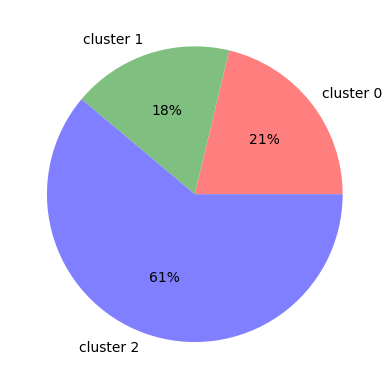

In [25]:
plt.pie((df_clust0.shape[0],df_clust1.shape[0],df_clust2.shape[0]), 
        labels = ["cluster 0","cluster 1","cluster 2"], 
        colors = ["#FF7F7F","#7FBF7F","#7F7FFF"], autopct='%.0f%%')
plt.show()

In [26]:
sns.set_palette("Set2")

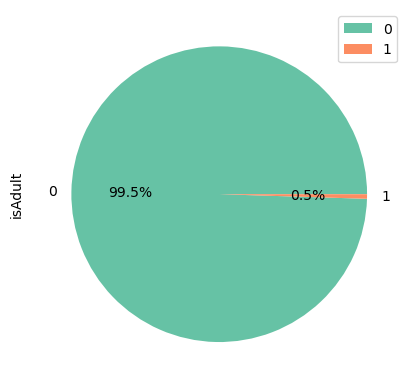

In [27]:
df_clust0.isAdult.value_counts().plot(kind="pie", legend=True, autopct='%1.1f%%')
plt.show()

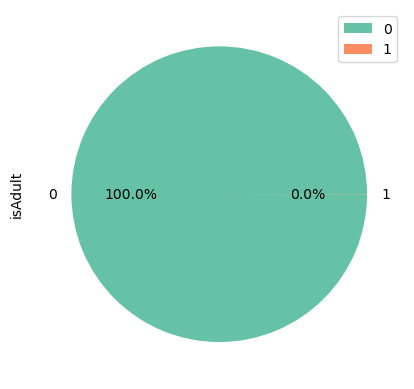

In [28]:
df_clust1.isAdult.value_counts().plot(kind="pie", legend=True, autopct='%1.1f%%')
plt.show()

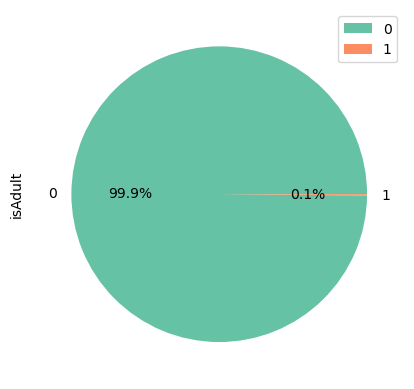

In [29]:
df_clust2.isAdult.value_counts().plot(kind="pie", legend=True, autopct='%1.1f%%')
plt.show()

<AxesSubplot: xlabel='averageRating', ylabel='Count'>

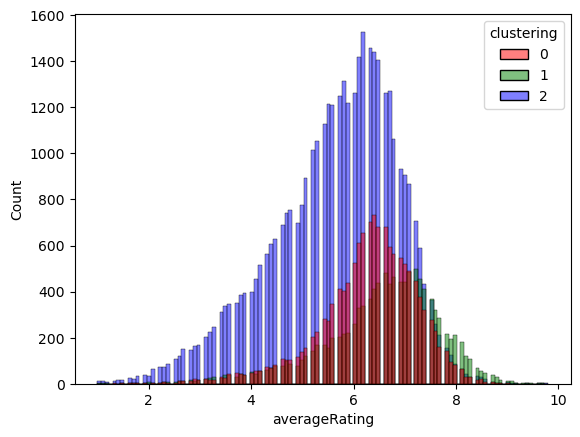

In [30]:
sns.histplot(data=df_clustall, 
             x="averageRating", 
             hue="clustering",
             palette = ["red","green","blue"])

<AxesSubplot:xlabel='decade', ylabel='Count'>

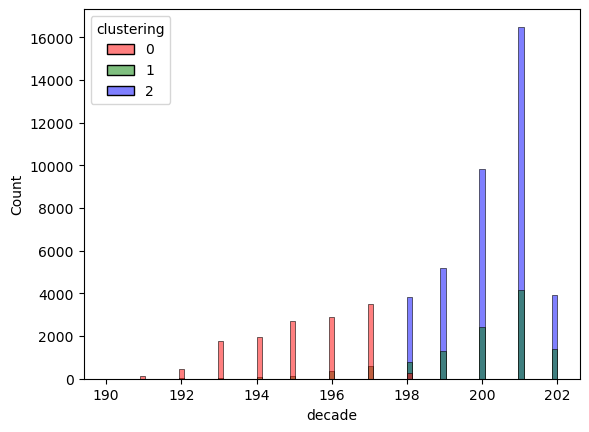

In [ ]:
sns.histplot(data=df_clustall, 
             x="decade", 
             hue="clustering",
             palette = ["red","green","blue"])

In [ ]:
df_clustall.columns

Index(['actors', 'averageRating', 'decade', 'runtimeMinutes', 'isAdult',
       'genres', 'directors', 'actress', 'clustering'],
      dtype='object')

<AxesSubplot:xlabel='runtimeMinutes', ylabel='Count'>

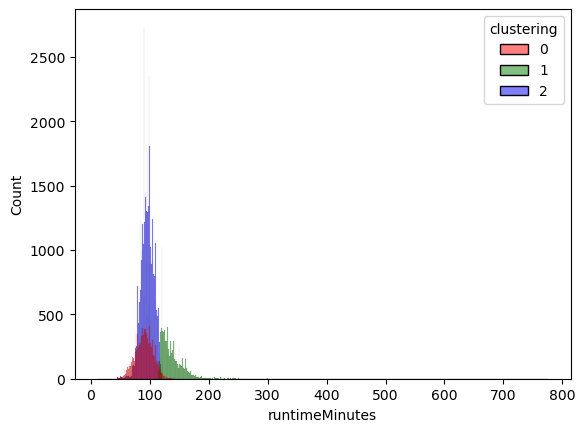

In [ ]:
sns.histplot(data=df_clustall, 
             x="runtimeMinutes", 
             hue="clustering",
             palette = ["red","green","blue"])

 ## (4) Mise en place d'un modèle de régression par cluster

on regarde si le modèle très basique que j'ai donne des res différents selon le cluster

In [ ]:
# cluster 0
data = df_clust0
model = GradientBoostingRegressor()
parameters = {'model__n_estimators': range(140, 160, 10), 'model__max_depth': range(6,8)}

model_testing(data, model, parameters)

In [ ]:
# cluster 1
data = df_clust1
model = GradientBoostingRegressor()
parameters = {'model__n_estimators': range(140, 150, 10), 'model__max_depth': range(6,7)}

model_testing(data, model, parameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV parameters: {'model__max_depth': 6, 'model__n_estimators': 140}
CV score - R2: 0.17922449388807649
Test score r2 0.19369516169500844
Test score MAE 0.7790508799228999


In [ ]:
# cluster 2
data = df_clust2
model = GradientBoostingRegressor()
parameters = {'model__n_estimators': range(140, 150, 10), 'model__max_depth': range(6,7)}

model_testing(data, model, parameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CV parameters: {'model__max_depth': 6, 'model__n_estimators': 140}
CV score - R2: 0.34392952807965266
Test score r2 0.3335176816609453
Test score MAE 0.6061740473082634


In [ ]:
# cluster 2 test sur randomforest
data = df_clust2
model = RandomForestClassifier()
parameters = {'model__n_estimators': range(100, 201, 50), 'model__max_depth': range(10,21,5)}

model_testing(data, model, parameters)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/sylvine/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
27 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sylvine/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sylvine/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/sylvine/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 367, in fit
    y, expanded_class_wei

ValueError: Unknown label type: 'continuous'

## (5) Recherche du meilleur modèle ar cluster, les 3 clusters en meme temps

Régressions classiques

In [ ]:
# reg lin ols
model = LinearRegression()
parameters = {}

model_testing_cluster(cluster_datasets, model, parameters)

In [ ]:
# Ridge
model = Ridge()
parameters = {'model__alpha': [3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]}

model_testing_cluster(cluster_datasets, model, parameters)

_______________________________________
Pour le dataset 0, le meilleur modèle est:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
CV parameters: {'model__alpha': 0.06}
CV score - R2: 0.31018963148519635
Test score r2 0.2979497166501973
Test score MAE 0.8112072105481336
_______________________________________
Pour le dataset 0, le meilleur modèle est:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
CV parameters: {'model__alpha': 0.06}
CV score - R2: -0.07377910350311685
Test score r2 -0.17304302608564703
Test score MAE 0.9338234886459864
_______________________________________
Pour le dataset 0, le meilleur modèle est:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
CV parameters: {'model__alpha': 0.06}
CV score - R2: 0.13836729031707176
Test score r2 0.1671626899145584
Test score MAE 0.6997837832598723


In [ ]:
# Lasso
model = Lasso()
parameters = {'model__alpha': [0.0001, 0.0002, 0.003]}

model_testing_cluster(cluster_datasets, model, parameters)

__________________________________________
Pour le dataset 0, le meilleur modèle est:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
CV parameters: {'model__alpha': 550}
CV score - R2: -0.0001522949659423419
Test score r2 -0.0005785809412013343
Test score MAE 0.9894418005178947
__________________________________________
Pour le dataset 1, le meilleur modèle est:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
CV parameters: {'model__alpha': 550}
CV score - R2: -6.755874466546352e-05
Test score r2 -2.4222094296977303e-05
Test score MAE 0.8862798554841922
__________________________________________
Pour le dataset 2, le meilleur modèle est:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
CV parameters: {'model__alpha': 550}
CV score - R2: -0.00021048779149975458
Test score r2 -0.0011694223872520393
Test score MAE 0.746292959102166


In [ ]:
# ElasticNet
model = ElasticNet()
parameters = {"model__alpha": [0.0001, 1, 100],"model__l1_ratio": np.arange(0.0, 1.0, 0.2)}
#parameters = {"model__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],"model__l1_ratio": np.arange(0.0, 1.0, 0.1)}

model_testing_cluster(cluster_datasets, model, parameters)

# a relancer avec un maxiter plus grand

Méthodes d'ensemble

In [ ]:
# gradient boosting
model = GradientBoostingRegressor()
parameters = {'model__n_estimators': range(100, 181, 20), 'model__max_depth': range(1,31,10)}
# 'model__learning_rate': range(0,11,2), 
model_testing_cluster(cluster_datasets, model, parameters)

_______________________________________
Pour le dataset 0, le meilleur modèle est:
Fitting 5 folds for each of 15 candidates, totalling 75 fits
CV parameters: {'model__max_depth': 11, 'model__n_estimators': 180}
CV score - R2: 0.3600195382334911
Test score r2 0.3714714727778695
Test score MAE 0.7563478153381318
_______________________________________
Pour le dataset 0, le meilleur modèle est:
Fitting 5 folds for each of 15 candidates, totalling 75 fits
CV parameters: {'model__max_depth': 21, 'model__n_estimators': 180}
CV score - R2: 0.19474716672197256
Test score r2 0.2233475473042461
Test score MAE 0.7596942041309867
_______________________________________
Pour le dataset 0, le meilleur modèle est:
Fitting 5 folds for each of 15 candidates, totalling 75 fits
CV parameters: {'model__max_depth': 11, 'model__n_estimators': 180}
CV score - R2: 0.3747029122960102
Test score r2 0.361936473649382
Test score MAE 0.585234411450113


In [ ]:
# AdaBoost
model = AdaBoostRegressor()
parameters = {'model__n_estimators': [157, 158]}
model_testing(df_clust0, model, parameters)

In [ ]:
# randomForest
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
parameters = {'model__n_estimators': range(100, 201, 100), 'model__max_depth': range(10,21,10)}

model_testing_cluster(cluster_datasets, model, parameters)